In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#import the dataset that will be used to develop this model
data = pd.read_csv('/content/drive/MyDrive/framingham_heart_study.csv')
data.head()

In [ ]:
#We need to drop columns that will not be used for this model
#To avoid noise and to promote model accuracy

In [ ]:
data.head()

In [ ]:
#Let's try to understand and clean the data
data.describe()

In [ ]:
data.info()

In [ ]:
#Let's check for missing values and duplicate
data.isnull().sum()

In [ ]:
data.duplicated().sum()

In [ ]:
# Fill missing values with the median
data.fillna(data.median(), inplace=True)

# Verify that there are no more missing values
print("Missing values after filling with median:")
print(data.isnull().sum())

In [ ]:
#let rename the columns for more readabilty
data.rename(columns={
    'male': 'gender',
    'age': 'age',
    'education': 'education_level',
    'currentSmoker': 'currently_smokes',
    'cigsPerDay': 'cigarettes_per_day',
    'BPMeds': 'bp_medication',
    'prevalentStroke': 'history_of_stroke',
    'prevalentHyp': 'has_hypertension',
    'diabetes': 'has_diabetes',
    'totChol': 'total_cholesterol',
    'sysBP': 'systolic_bp',
    'diaBP': 'diastolic_bp',
    'BMI': 'bmi',
    'heartRate': 'heart_rate',
    'glucose': 'glucose_level',
    'TenYearCHD': 'cvd_risk'
}, inplace=True)

data.head()

Let perform some data exploratory analysis to understand the data

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='gender', hue='cvd_risk')
plt.title('Count of CVD Risk by Gender')
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

In [ ]:
# Group by gender and cvd_risk and count the occurrences
gender_cvd_counts = data.groupby(['gender', 'cvd_risk']).size().unstack(fill_value=0)

# Calculate the percentage of CVD risk within each gender
gender_cvd_counts['Total'] = gender_cvd_counts[0] + gender_cvd_counts[1]
gender_cvd_counts['CVD_Risk_Percentage'] = (gender_cvd_counts[1] / gender_cvd_counts['Total']) * 100

print("Percentage of CVD Risk by Gender:")
print(gender_cvd_counts[['CVD_Risk_Percentage']])

The above code shows the gender with more risk to cardiovascular diseases


In [ ]:
#Let check if the data is imbalanced
sns.countplot(data=data, x='cvd_risk')
plt.title('Count of CVD Risk')
plt.xticks([0, 1], ['No CVD', 'CVD'])
plt.show()

In [ ]:
#We need to compare age distrubution by risk
sns.boxplot(x='cvd_risk', y='age', data=data)
plt.title("Age Distribution by CVD Risk")
plt.xticks([0, 1], ['No CVD', 'CVD'])
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

In [ ]:
print(data.groupby('cvd_risk')[['age', 'total_cholesterol', 'bmi', 'glucose_level']].mean())


In [ ]:
data.head()

In [ ]:
#We need to drop two columns that is not needed for this model development
data.drop(columns=['education_level','heart_rate'], inplace=True)

print("Columns after dropping:")
print(data.columns)

In [ ]:
data.isnull().sum()

Now let's develop the model using XGBoost.

In [ ]:
#let's split the dataset into X and Y
X = data.drop('cvd_risk', axis=1)
y = data['cvd_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [ ]:
#Calculate class weights
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")

In [ ]:
model = XGBClassifier(
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#Train the model
model.fit(X_train, y_train)

#Predict on test data
y_pred = model.predict(X_test)

#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

**Model Performance Summary and Improvement Plan**

After training the XGBoost model on the cleaned cardiovascular dataset, the results showed an overall accuracy of 78.5%. However, a deeper look into the performance revealed some important issues:

    The model performed well on class 0 (people without CVD), with high precision and recall.

    But it struggled with class 1 (people with CVD), showing a low F1-score of 0.22 and recall of only 19%.

    This means the model misses most of the people who actually have cardiovascular disease, which is a serious concern in real-world applications.

**Confusion Matrix:**

Out of 129 people who actually had CVD:

    The model correctly predicted only 25

    It wrongly classified 104 as “no risk”

This is caused by class imbalance in the data — the number of “no risk” cases is much higher than the number of “at risk” cases. As a result, the model is biased toward predicting 0 (no CVD).

**Plan to Improve the Model**

To solve this problem, I will use SMOTE (Synthetic Minority Oversampling Technique) on the training data. SMOTE will help by:

    Generating new synthetic examples of class 1 (CVD)

    Making the training data more balanced

    Helping the model learn patterns for people at risk

This should improve the model's ability to correctly detect people with CVD, increasing both recall and F1-score.

In [ ]:
#Solutions to solve the biased model
from imblearn.over_sampling import SMOTE

#Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

#Re-train XGBoost model
model_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model_smote.fit(X_train_bal, y_train_bal)

#Evaluate on original test set
y_pred_bal = model_smote.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("F1 Score:", f1_score(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

After applying SMOTE to balance the training data, the XGBoost model was retrained. This method aimed to improve the model’s ability to detect cardiovascular risk cases (class 1).

However, the results still show a low recall (16%) and F1-score (0.19) for the positive class. This means the model still misses many true CVD cases.

Although SMOTE helped balance the data, the underlying problem seems to be feature strength — the current features may not clearly separate those at risk from those not at risk.

This shows that balancing alone is not enough. The model may benefit from:

    Tuning more XGBoost hyperparameters

    Adding better or engineered features

    Trying other models for comparison

In [ ]:
# We need to know which feature the model uses alot for it's decision

# Get feature importance scores
importance_scores = model_smote.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

The feature importance plot shows that the top predictors of cardiovascular disease in this dataset are:

    Smoking status (currently_smokes)

    Use of blood pressure medication (bp_medication)

    Age

    Cigarettes per day

These features have the highest impact on the model's decisions. On the other hand, features like history_of_stroke, has_diabetes, and bmi had relatively low importance. This may be due to limited variation in those columns or their overlap with other features.

Understanding feature importance helps us explain how the model makes decisions, and can guide future improvements, such as collecting better health indicators or engineering new features.

In [ ]:
# Define base XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define small grid of parameters (fast to run)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit on SMOTE-balanced training data
grid_search.fit(X_train_bal, y_train_bal)

# Show best parameters
print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# Save best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters from GridSearchCV:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


After evaluating the initial model performance, I applied SMOTE to correct the class imbalance problem in the dataset. This step helped balance the number of people with and without cardiovascular disease, which gave the model a fairer chance to learn both cases.

Next, I used GridSearchCV to find the best hyperparameters for the XGBoost model. This process tested multiple combinations of important settings like tree depth, learning rate, and number of estimators. The best performing parameters found were:

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

With these settings, the model is now better optimized to identify patients at risk of cardiovascular disease, although there's still room for improvement in recall. The process showed that just balancing the data isn't enough — careful tuning and understanding feature importance are also necessary.

This optimized model will now be used in the next step of this project: deployment using Streamlit, where users will be able to input patient data and receive real-time risk predictions.

In [ ]:
y_pred_best = best_model.predict(X_test)

print(" F1 Score:", f1_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

 F1 Score: 0.21311475409836064

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       719
           1       0.23      0.20      0.21       129

    accuracy                           0.77       848
   macro avg       0.54      0.54      0.54       848
weighted avg       0.76      0.77      0.77       848


Confusion Matrix:
 [[630  89]
 [103  26]]


The main goal of all these steps — balancing, tuning, and evaluation — is to make the model better at correctly identifying people who are truly at risk of cardiovascular disease. This is important because missing a high-risk case can have serious health consequences. The goal is not just to achieve high accuracy, but to build a model that is both accurate and sensitive enough to support real-world health decision-making.

After optimizing XGBoost and applying SMOTE, results were still limited by low recall and F1-score for detecting at-risk patients. As a next step, I explored alternative models to compare performance and confirm whether XGBoost is the best option or if another model handles this data better.

In [ ]:
# We need to try other algorithm to see if we can fix the issue with F1 and recall

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(class_weight='balanced', probability=True, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name}")
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    results.append({
        'Model': name,
        'F1 Score': round(f1, 3)
    })

# Display summary
import pandas as pd
summary_df = pd.DataFrame(results)
print("\nModel Comparison Summary:")
print(summary_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression
F1 Score: 0.33093525179856115
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       719
           1       0.24      0.53      0.33       129

    accuracy                           0.67       848
   macro avg       0.57      0.62      0.56       848
weighted avg       0.79      0.67      0.71       848

Confusion Matrix:
[[500 219]
 [ 60  69]]

Random Forest
F1 Score: 0.20833333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       719
           1       0.23      0.19      0.21       129

    accuracy                           0.78       848
   macro avg       0.54      0.54      0.54       848
weighted avg       0.76      0.78      0.77       848

Confusion Matrix:
[[633  86]
 [104  25]]

Support Vector Machine
F1 Score: 0.3541666666666667
Classification Report:
              precision    recall  f1-score   

After comparing several classification models, the Support Vector Machine (SVM) emerged as the best performer for cardiovascular disease prediction. It achieved the highest recall (66%) and F1-score (0.35) for the positive class (CVD), meaning it was the most effective at correctly identifying individuals at risk.

While it had lower overall accuracy than some other models, its ability to reduce false negatives is more valuable in medical contexts, where missing a high-risk patient can lead to serious consequences. This makes SVM the most suitable model for deployment in this system.

In [ ]:
# Now let's use SVM algorithm for this model
# This is your final, selected model

final_model = SVC(class_weight='balanced', probability=True, random_state=42)
final_model.fit(X_train_bal, y_train_bal)

SVC(class_weight='balanced', probability=True, random_state=42)

In [ ]:
y_pred_final = final_model.predict(X_test)

print("Final SVM Model Evaluation:")
print("F1 Score:", f1_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

Final SVM Model Evaluation:
F1 Score: 0.3541666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.63      0.75       719
           1       0.24      0.66      0.35       129

    accuracy                           0.63       848
   macro avg       0.58      0.64      0.55       848
weighted avg       0.81      0.63      0.69       848

Confusion Matrix:
 [[453 266]
 [ 44  85]]


This model achieved the highest recall and F1-score for class 1, so it was selected for deployment.

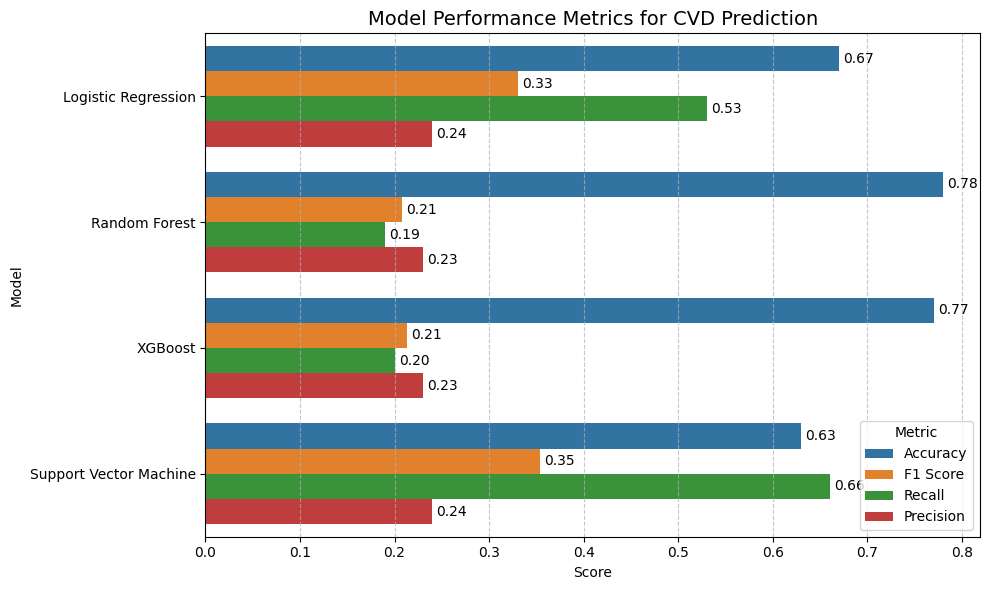

In [ ]:
# Performance results we got from each algorithm to create this model

results_df = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'Random Forest', 'XGBoost',
        'Support Vector Machine'
    ],
    'Accuracy': [
        0.67,
        0.78,
        0.77,
        0.63
    ],
    'F1 Score': [
        0.331,
        0.208,
        0.213,
        0.354
    ],
    'Recall': [
        0.53,
        0.19,
        0.20,
        0.66
    ],
    'Precision': [
        0.24,
        0.23,
        0.23,
        0.24
    ]
})

results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
figsize = (10, 6)
plt.figure(figsize=figsize)
ax = sns.barplot(data=results_melted, x='Score', y='Model', hue='Metric')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title("Model Performance Metrics for CVD Prediction", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Metric", loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Running some test before saving the model


In [ ]:
sample_input = pd.DataFrame([{
    'gender': 1,
    'age': 32,
    'currently_smokes': 0,
    'cigarettes_per_day': 20,
    'bp_medication': 1,
    'history_of_stroke': 0,
    'has_hypertension': 0,
    'has_diabetes': 0,
    'total_cholesterol': 250,
    'systolic_bp': 145,
    'diastolic_bp': 90,
    'bmi': 28.5,
    'glucose_level': 105
}])

# Make prediction
prediction = final_model.predict(sample_input)

# get probability (if needed)
probability = final_model.predict_proba(sample_input)

# Print result
result = "High Risk (CVD)" if prediction[0] == 1 else "Low Risk"
print(f" Prediction: {result}")
print(f"Probability (class 1 - CVD): {probability[0][1]:.2f}")

 Prediction: Low Risk
Probability (class 1 - CVD): 0.29


Let's save the model




In [ ]:
import joblib

joblib.dump(final_model, 'cvd_prediction_model.pkl')

print('Model successful saved as cvd_prediction_model')

Model successful saved as cvd_prediction_model


Let's also save the model on Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


joblib.dump(final_model, '/content/drive/MyDrive/cvd_prediction_model.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/cvd_prediction_model.pkl']

In [ ]:
from google.colab import files
files.download('cvd_prediction_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://script.google.com/macros/s/AKfycbzn08xyprH1K8Fz7SjZs04ijkVcZHPkDV54ZrdKxboGCvhuPV3T3Vl9BR1umI7VA-D_/exec